# Single-Object Detection

La détection d'objets est le processus de recherche d'emplacements d'objets spécifiques dans des images. Selon le nombre d'objets dans les images, on peut traiter des problèmes de détection mono-objet ou multi-objets. Cet article se concentrera sur le développement d'un modèle d'apprentissage en profondeur utilisant PyTorch pour effectuer la détection d'un seul objet. Dans la détection d'objet unique, nous essayons de ne localiser qu'un seul objet dans une image donnée. L'emplacement de l'objet peut être défini par une boîte englobante.


Nous pouvons représenter une boîte englobante avec quatre nombres dans l'un des formats suivants :
* [x0, y0, w, h]
* [x0, y0, x1, y1]
* [xc, yc, w, h]

Ici, les éléments précédents représentent les éléments suivants:

* x0, y0 : les coordonnées du coin supérieur gauche du cadre englobant
* x1, y1 : les coordonnées du bas à droite du cadre englobant
* w, h : la largeur et la hauteur du cadre englobant
* xc, yc : les coordonnées du centroïde du cadre englobant.


Par conséquent, le but de la détection d'un seul objet sera de prédire une boîte englobante à l'aide de quatre nombres. Dans le cas d'objets carrés, nous pouvons fixer la largeur et la hauteur et simplifier le problème pour ne prédire que deux nombres. ici, nous allons apprendre à créer un algorithme pour localiser la fovéa dans les images oculaires à l'aide de deux nombres.


Dans cet article , nous aborderons les recettes suivantes :
 
* Analyse exploratoire des données 
* Transformation des données pour la détection d'objets
* Création d'ensembles de données personnalisés
*  Création du modèle
* Définition de la métrique de perte, et optimiser et la metric IOU 
* Entraînement et évaluation du modèle
*  Déploiement du modèle

## Exploratory data analysis

L'analyse exploratoire des données est généralement effectuée pour comprendre les caractéristiques des données. Dans l'analyse exploratoire des données, nous inspecterons notre ensemble de données et visualiserons des échantillons ou des caractéristiques statistiques de nos données à l'aide de boîtes à moustaches, d'histogrammes et d'autres outils de visualisation. Par exemple, pour les données tabulaires, nous aimerions voir les colonnes, quelques lignes, un certain nombre d'enregistrements et des mesures statistiques, telles que la moyenne et l'écart type de nos données. Pour les données d'imagerie, nous afficherions des exemples d'images, d'étiquettes ou de cadres de délimitation des objets dans les images.

Nous utiliserons les données du concours iChallenge-AMD sur le site du Grand Challenge. Ce concours comporte plusieurs tâches, notamment la classification, la localisation et la segmentation. Nous nous intéressons uniquement à la tâche de localisation. Dans cette recette, nous allons explorer l'ensemble de données iChallenge-AMD.

### Téléchargeons le jeu de données iChallenge-AMD

Pour trouver l'ensemble de données, visitez https://amd.grand-challenge.org/.

* **1.** Pour pouvoir télécharger les données, vous devez créer un compte gratuit.Sélectionnez la section Téléchargement dans la barre latérale 

* **.2.** Cliquez sur les images et les étiquettes AMD.

Pour explorer l'ensemble de données, nous commençons par charger les étiquettes et afficher des exemples d'images



In [1]:
! cp /content/drive/MyDrive/data/AMD-Training400.zip /content/

In [3]:
#!unzip AMD-Training400.zip

In [9]:
import os
import pandas as pd

path2data="./"

# full path of labels file
path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

# maske sure to install xlrd
labels_df=pd.read_excel(path2labels,index_col="ID")

labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [10]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


Ensuite, nous montrerons le nuage de points des coordonnées Fovea_X et Fovea_Y

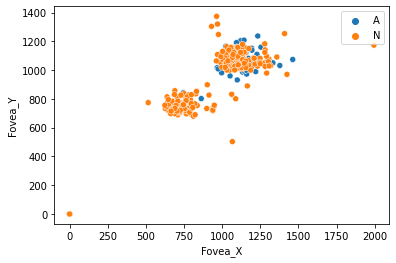

In [11]:
# make sure seaborn is installed!
import seaborn as sns
%matplotlib inline

AorN=[imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'],hue=AorN)

Ensuite, nous allons montrer quelques exemples d'images. Nous allons importer les packages requis et corriger la graine aléatoire :

In [13]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

In [14]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows,ncols=2,3

<Figure size 1080x648 with 0 Axes>

Ensuite, nous sélectionnerons un ensemble aléatoire d'identifiants d'image :

In [15]:
# get imgName column
imgName=labels_df["imgName"]

# get ids
ids=labels_df.index

# select random ids
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 73 371 160 294 217 191]


Ensuite, nous allons définir une fonction d'assistance pour charger une image et son étiquette à partir des fichiers locaux

In [16]:

def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

In [17]:
def show_img_label(img,label,w_h=(50,50),thickness=2):   
    w, h = w_h                   
    cx, cy=label
    
    # draw a rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=thickness)

    plt.imshow(np.asarray(img))

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


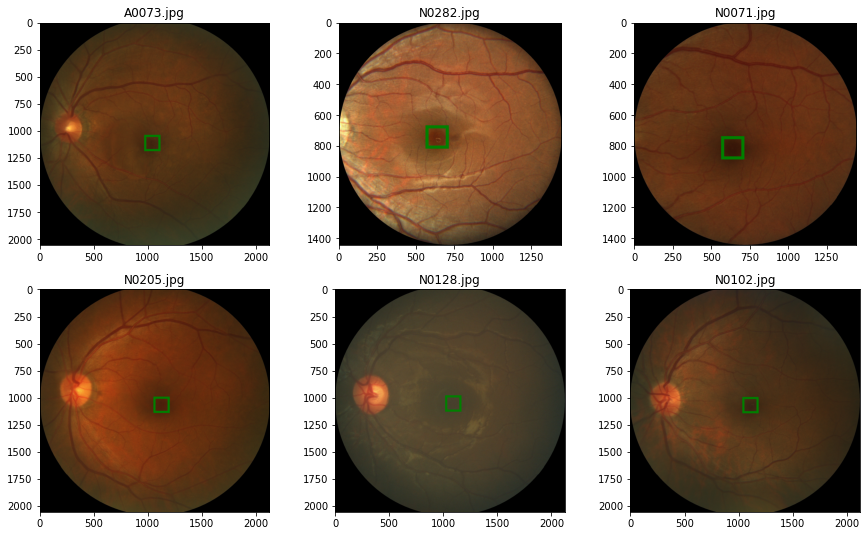

In [18]:
for i,id_ in enumerate(rndIds):
    
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

Ensuite, nous allons collecter les largeurs et les hauteurs des images dans deux listes

In [19]:

h_list,w_list=[],[]
for id_ in ids:
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
        
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
        
    # load image
    img = Image.open(fullPath2img)
    h,w=img.size
    h_list.append(h)
    w_list.append(w)

Ensuite, nous tracerons les distributions des hauteurs et des largeurs

Tracez la distribution des hauteurs d'image comme suit

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


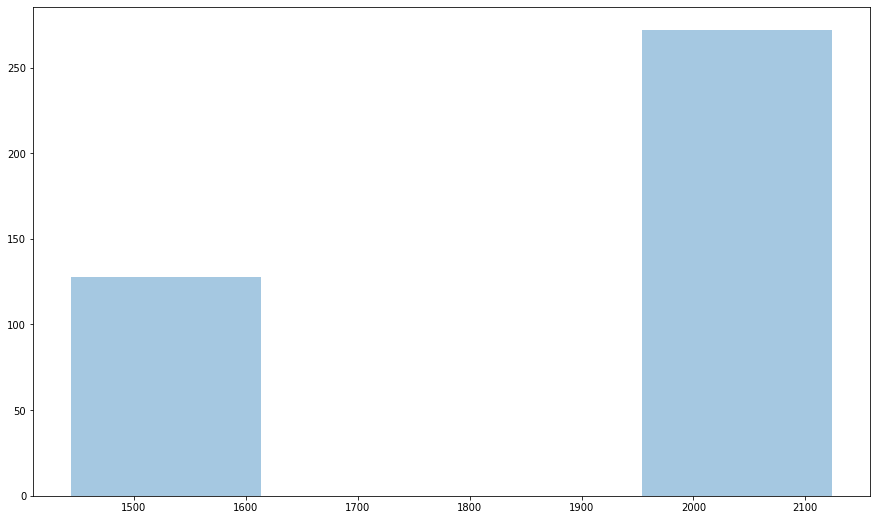

In [20]:

sns.distplot(a=h_list, kde=False)

Ensuite, nous allons tracer la distribution des largeurs d'image

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


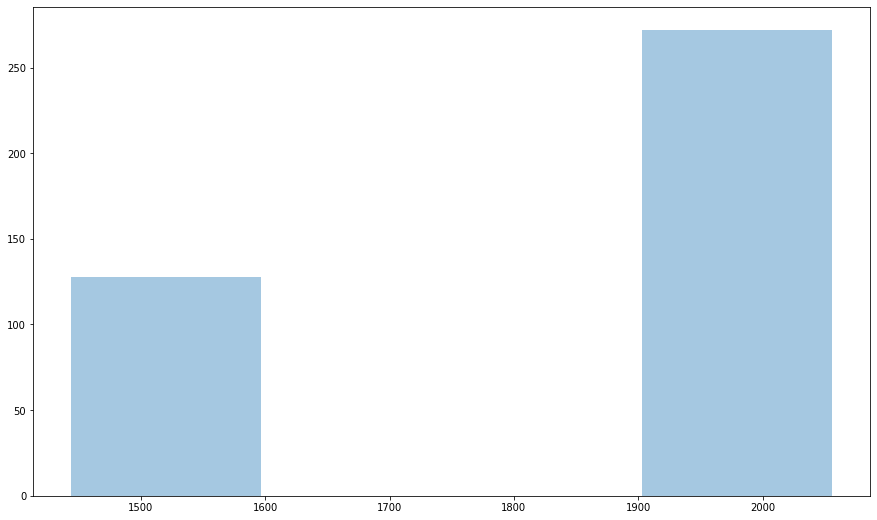

In [21]:
sns.distplot(a=w_list, kde=False)

## Data transformation for object detection

L'augmentation et la transformation des données sont une étape critique dans la formation d'algorithmes d'apprentissage en profondeur, en particulier pour les petits ensembles de données. L'ensemble de données iChallenge-AMD de ce chapitre ne contient que 400 images, ce qui est considéré comme un petit ensemble de données. Pour rappel, nous diviserons plus tard 20 % de cet ensemble de données à des fins d'évaluation. Étant donné que les images ont des tailles différentes, nous devions redimensionner toutes les images à une taille prédéterminée. Ensuite, nous pouvons utiliser une variété de techniques d'augmentation, telles que le retournement horizontal, le retournement vertical et la translatation, pour étendre notre ensemble de données pendant la formation.


Dans les tâches de détection d'objets, lorsque nous effectuons de telles transformations sur des images, nous devons également mettre à jour les étiquettes. Par exemple, lorsque nous retournons une image horizontalement, l'emplacement des objets dans l'image change. Alors que torchvision.transforms fournit des fonctions utilitaires pour les transformations d'images, nous devons créer nos propres fonctions pour mettre à jour les étiquettes. Dans cette recette, nous allons développer un pipeline pour transformer des images et des étiquettes en détection d'objet unique. Nous développerons le retournement horizontal, le retournement vertical, la translatation et le redimensionnement. Vous pouvez ensuite ajouter d'autres transformations au pipeline selon vos besoins.

Nous allons créer un pipeline de transformation de données pour la détection d'un seul objet :

* **1.** Tout d'abord, nous allons définir une fonction d'assistance pour redimensionner les images

In [22]:

import torchvision.transforms.functional as TF

def resize_img_label(image, label=(0.,0.), target_size=(256,256)):
    w_orig, h_orig = image.size   
    w_target, h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

Essayons de redimensionner une image à l'aide de la fonction précédente :

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


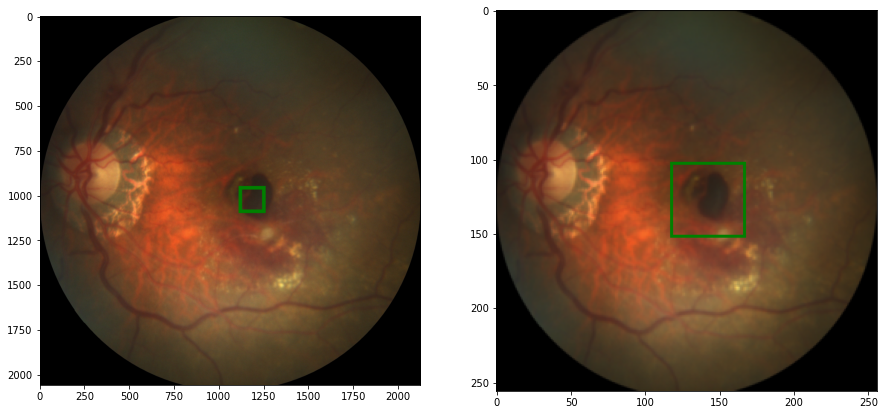

In [23]:
# load image
img, label=load_img_label(labels_df,1)   
print(img.size,label)

img_r,label_r=resize_img_label(img,label)
print(img_r.size,label_r)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(img_r,label_r)

En outre, l'extrait précédent représente les images d'origine et redimensionnées et les cadres de délimitation de la fovéa, comme dans la capture d'écran suivante.

* **2.** Ensuite, nous allons définir une fonction d'assistance pour retourner les images au hasard horizontalement

In [25]:
def random_hflip(image,label):
    w, h = image.size
    x, y = label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

Essayons de retourner une image en utilisant la fonction précédente :

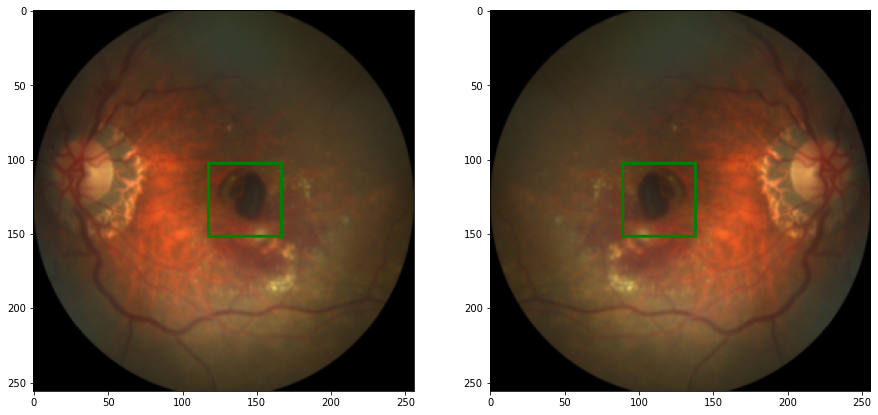

In [26]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_fh,label_fh=random_hflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fh,label_fh)

* **3.** Ensuite, nous allons définir une fonction pour retourner aléatoirement les images verticalement

In [27]:
def random_vflip(image,label):
    w,h=image.size
    x,y=label

    image = TF.vflip(image)
    label = x, h-y
    return image, label

Essayons de retourner une image en utilisant la fonction précédente :

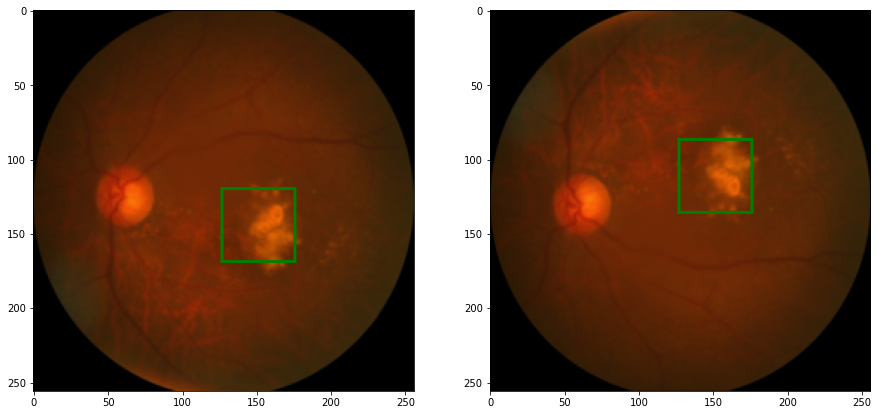

In [28]:
# load image and label
img, label=load_img_label(labels_df,7)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# vertical flip
img_fv,label_fv=random_vflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fv,label_fv)

* **4.** Ensuite, nous allons définir une fonction d'assistance pour déplacer ou traslater aléatoirement les images dans les deux sens

In [30]:
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate=(0.2, 0.2)):
    w, h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label

    # translate coeficinet, random [-1,1]
    trans_coef = np.random.rand()*2-1
    w_t = int(trans_coef * max_t_w * w)
    h_t = int(trans_coef * max_t_h * h)

    image=TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    label = cx + w_t, cy + h_t
        
    return image, label

Essayons de translater une image en utilisant la fonction random_shift

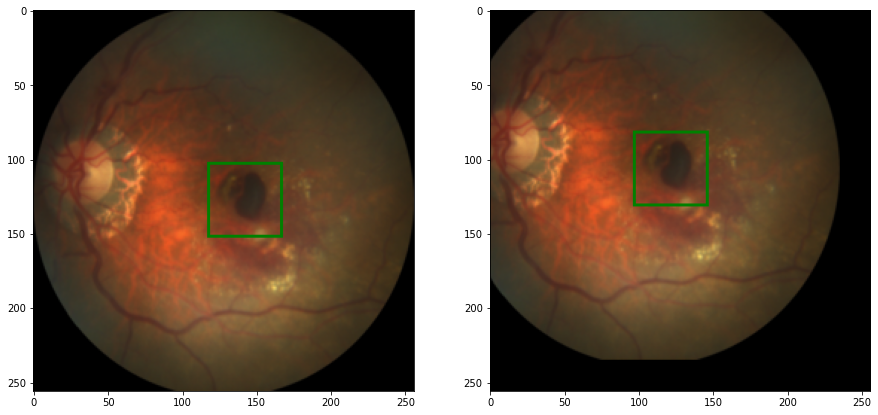

In [31]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_t,label_t=random_shift(img_r,label_r,max_translate=(.5,.5))

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

* **5.** Ensuite, nous allons composer plusieurs transformations en une seule fonction 

In [32]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    
    if random.random() < params["p_hflip"]:
        image, label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image, label = random_vflip(image, label)
        
    if random.random() < params["p_shift"]:                            
        image, label = random_shift(image, label, params["max_translate"])
        
    image = TF.to_tensor(image)
    return image, label

Essayons de transformer une image à l'aide de transformer :

In [33]:

import random
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)   

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.2, 0.2),
}
img_t,label_t=transformer(img,label,params)

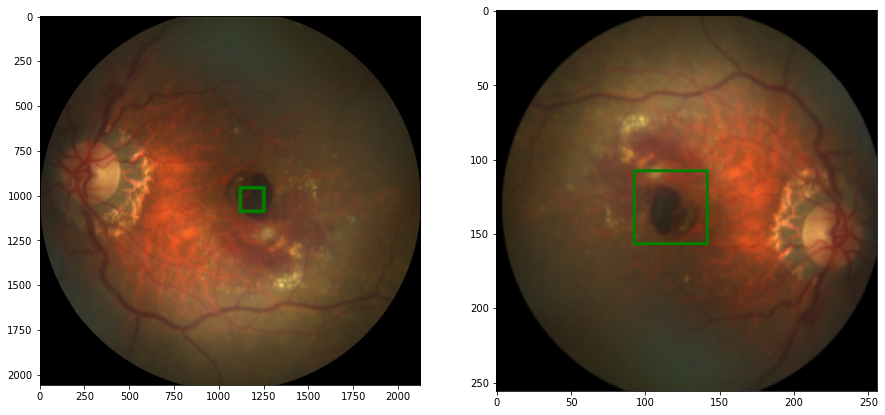

In [34]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

Il existe d'autres types de transformations que vous pouvez appliquer aux images pour l'augmentation des données. Certains d'entre eux ne nécessitent aucune mise à jour de l'étiquette.

Par exemple, nous pouvons créer de nouvelles images en ajustant la luminosité, comme indiqué dans le bloc de code suivant

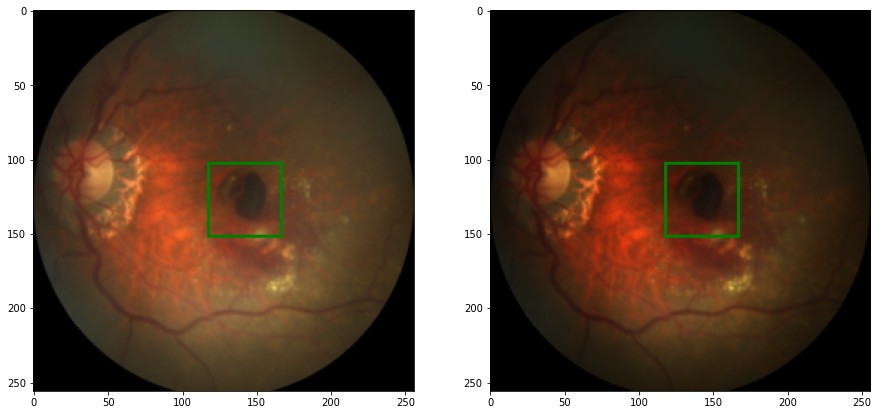

In [35]:
img, label=load_img_label(labels_df,1)

# resize image and label

img_r,label_r=resize_img_label(img,label)

# brightness
img_t=TF.adjust_contrast(img_r,contrast_factor=0.4)
label_t=label_r

# gamma correction
img_t = TF.adjust_gamma(img_r, gamma=1.4)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

Il y a une autre transformation que nous effectuons habituellement sur les étiquettes. Dans cette transformation, nous mettons les étiquettes à l'échelle dans la plage de [0, 1] en utilisant la fonction suivante

In [ ]:
def scale_label(a, b):
    div = [ai/bi for ai, bi in zip(a,b)]
    return div

In [51]:
def transformer(image, label, params):

    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor = 1+ (np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label = scale_label(label, params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

In [36]:

np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)

In [37]:

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}

img_t,label_t=transformer(img,label,params)

In [88]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div
    
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

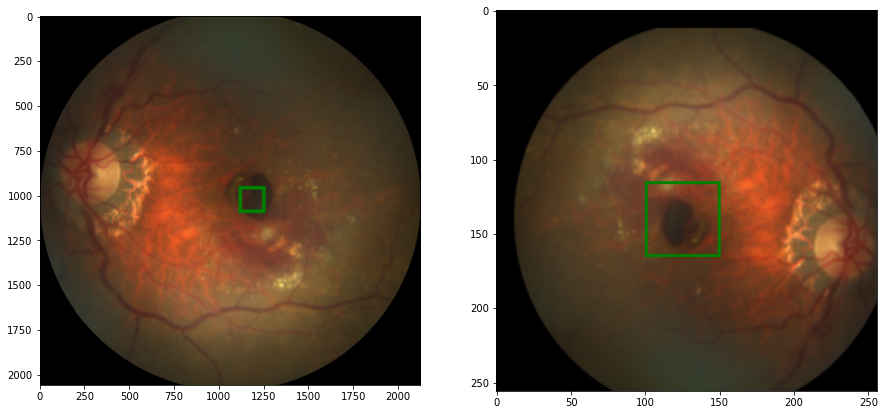

In [38]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

# Creating custom datasets

Dans cette recette, nous utiliserons la classe Dataset de torch.utils.data pour créer des ensembles de données personnalisés pour le chargement et le traitement des données. Nous pouvons le faire en sous-classant la classe Dataset et en remplaçant les fonctions __init__ et __getitem__. La fonction __len__ renvoie la longueur de l'ensemble de données et est appelable avec la fonction Python len. La fonction __getitem__ renvoie une image à l'index spécifié. Ensuite, nous utiliserons la classe Dataloader detorch.utils.data pour créer des chargeurs de données. En utilisant des chargeurs de données, nous pouvons obtenir automatiquement des mini-lots de données à traiter.

Définissons une classe de jeu de données personnalisée. Tout d'abord, nous allons charger les packages requis



In [89]:
from torch.utils.data import Dataset
from PIL import Image


class AMD_dataset(Dataset):

    def __init__(self, path2data, transform, trans_params):      
        # full path of the labels file
        path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

        # read and extract labels
        labels_df=pd.read_excel(path2labels,index_col="ID")
        self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

        # extract ID and imgName columns
        self.imgName = labels_df["imgName"]
        self.ids = labels_df.index

        self.fullPath2img=[0]*len(self.ids)
        for id_ in self.ids:
            if self.imgName[id_][0]=="A":
                prefix="AMD"
            else:
                prefix="Non-AMD"
            self.fullPath2img[id_-1] = os.path.join(path2data,"Training400",prefix,self.imgName[id_])

        self.transform = transform
        self.trans_params = trans_params    
      
    def __len__(self):
        # return size of dataset
        return len(self.labels)
      
    def __getitem__(self, idx):
        # load PIL image
        image = Image.open(self.fullPath2img[idx])  
        label= self.labels[idx]

        # transform to tensor
        image,label = self.transform(image,label, self.trans_params)

        return image, label

Ensuite, nous allons créer deux objets de AMD_dataset

In [90]:
trans_params_train = {
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True
    }

In [91]:

trans_params_val={
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True   
}

In [92]:
amd_ds1 = AMD_dataset(path2data, transformer, trans_params_train)
amd_ds2 = AMD_dataset(path2data, transformer, trans_params_train)

Ensuite, nous diviserons l'ensemble de données en ensembles d'apprentissage et de validation

In [96]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [97]:

from torch.utils.data import Subset

train_ds = Subset(amd_ds1, train_index)
print(len(train_ds))

val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

320
80


Montrons maintenant un exemple d'image de train_ds et val_ds

In [98]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

In [99]:

def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label(label,img.shape[1:])        
        x,y=label
        plt.plot(x,y,'b+',markersize=20)

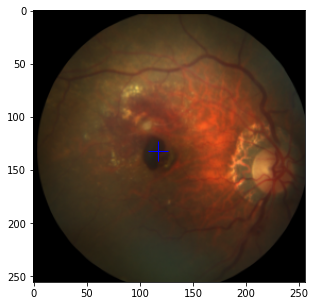

In [100]:

plt.figure(figsize=(5,5))
for img,label in amd_ds1:
    show(img, label)
    break

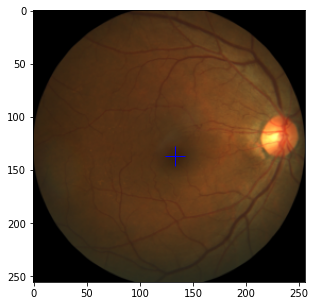

In [101]:
plt.figure(figsize=(5,5))
for img,label in val_ds:
    show(img,label)
    break

Ensuite, nous allons définir deux chargeurs de données pour les ensembles de données d'entraînement et de validation :

In [102]:

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [103]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.5731, 0.5441, 0.5745, 0.5012, 0.7118, 0.5137, 0.4719, 0.6507],
       dtype=torch.float64), tensor([0.5190, 0.5445, 0.4815, 0.5113, 0.7013, 0.4496, 0.5597, 0.6432],
       dtype=torch.float64)]


In [104]:
import torch

# extract a batch from trainin data
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)

    # convert list to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


In [105]:
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)

    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


## Creating the model

Dans cette recette, nous allons construire un modèle pour notre problème de détection d'objet unique. Dans notre problème, nous nous intéressons à la prédiction du centre de la fovéa sous forme de coordonnées x et y dans une image oculaire. Nous allons construire un modèle composé de plusieurs couches convolutives et de pooling pour cette tâche.

Le modèle recevra une image RGB redimensionnée et fournira deux sorties linéaires correspondant aux coordonnées de la fovéa. Si vous souhaitez prédire la largeur ou la hauteur d'une boîte abondante pour d'autres problèmes, vous pouvez simplement augmenter le nombre de sorties à quatre. Dans notre modèle, nous utiliserons la technique de connexion par saut introduite dans l'article dit ResNet.

In [106]:
import torch.nn as nn
import torch.nn.functional as F

In [108]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [109]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in, H_in, W_in = params["input_shape"]
    init_f = params["initial_filters"] 
    num_outputs = params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [110]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x = F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x

In [111]:
Net.__init__=__init__
Net.forward=forward

In [114]:
params_model={
        "input_shape": (3, 256, 256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }

model = Net(params_model)

In [129]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)
else:
  device = 'cpu'


In [115]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


## Defining the loss, optimizer, and IOU metric

Dans cette recette, nous allons d'abord définir une fonction de perte pour notre problème de détection d'objet unique. Les fonctions de perte courantes pour les tâches de détection sont l'erreur quadratique moyenne (MSE) et la perte smoothed-L1 loss. La perte smoothed-L1 loss utilise un terme au carré si l'erreur absolue par élément est inférieure à 1, et un terme L1 dans le cas contraire. Elle est moins sensible aux valeurs aberrantes que la MSE et, dans certains cas, évite l'explosion des gradients. Nous utiliserons la perte smoothed-L1 loss. Pour plus de détails sur la perte L1 lissée, visitez https://pytorch.org/docs/stable/nn.html#smoothl1loss.

Ensuite, nous définirons l'optimiseur pour mettre à jour automatiquement les paramètres du modèle. Enfin, nous définirons une métrique de performance pour notre détection d'objets appelée indice Jaccard, ou Intersection over Union (IOU). Une représentation graphique de l'IOU est montrée dans le diagramme suivant


 <img src='https://makina-corpus.com/blog/metier/images/iou_equation' width=400px>




Tout d'abord, nous allons définir la fonction de perte

In [116]:

loss_func = nn.SmoothL1Loss(reduction="sum")

Essayons la perte avec des valeurs connues

In [117]:

n, c = 8, 2
y = 0.5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0
24.0


Ensuite, nous allons définir l'optimiseur

In [118]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

Ensuite, nous allons définir une fonction d'assistance pour lire le taux d'apprentissage

In [119]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


Ensuite, nous allons définir un barème de taux d'apprentissage

In [120]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [121]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


Ensuite, nous allons définir une fonction pour calculer l'IOU pour un lot de données

In [123]:
def cxcy2bbox(cxcy,w=50./256, h=50./256):
    # define two new tensors for w and h
    w_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device)*w
    h_tensor = torch.ones(cxcy.shape[0],1, device=cxcy.device)*h

    # extract cx and cy
    cx = cxcy[:,0].unsqueeze(1)
    cy = cxcy[:,1].unsqueeze(1)
    
    # concat cx,cy,w and h
    boxes = torch.cat((cx, cy, w_tensor, h_tensor), -1) # cx,cy,w,h
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

In [124]:
torch.manual_seed(0)

cxcy = torch.rand(1,2)
print("center:", cxcy*256)

bb = cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [127]:
import torchvision
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    
    iou = torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

In [130]:
n, c = 8,2
target = torch.rand(n, c, device=device)
target = cxcy2bbox(target)
metrics_batch(target,target)

8.0

In [131]:
def loss_batch(loss_func, output, target, opt=None):   
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [132]:
for xb,label_b in train_dl:
    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    label_b=label_b.to(device)
 
    l,m=loss_batch(loss_func,label_b,label_b)
    print(l,m)
    break

0.0 8.0


À l'étape 1, nous avons d'abord défini la fonction de perte L1 à partir du package torch.nn. Notez que nous avons utilisé reduction="sum" pour renvoyer la somme des erreurs par mini-lot. Ensuite, nous avons calculé la valeur de la perte avec des valeurs connues. Il est toujours avantageux de tester unitairement la fonction de perte en utilisant des entrées et des sorties connues. Dans ce cas, nous définissons les prédictions sur 0,5 ou 1,5 valeurs et les valeurs cibles sur des valeurs entièrement nulles. Pour une taille de lot de 8 et 2 prédictions, cela a conduit à l'impression de 2,0 et 16,0. Plus tard, nous utiliserons loss.backward() pour calculer les gradients de la perte par rapport aux paramètres du modèle.

à l'étape 2, nous avons défini un optimiseur Adam à partir du package torch.optim. Les paramètres du modèle et le taux d'apprentissage seront donnés à l'optimiseur. Plus tard, nous utiliserons la méthode .step pour mettre à jour automatiquement les paramètres du modèle à l'aide de cet optimiseur. De plus, nous avons défini une fonction pour lire le taux d'apprentissage à des fins de surveillance.

À l'étape 3, nous avons défini un calendrier de taux d'apprentissage pour réduire le taux d'apprentissage . Ici, nous voulons surveiller la perte au fur et à mesure qu'elle diminue, nous définissons donc mode="min". Nous voulons également attendre patience=20 époques sur le plateau avant de réduire le taux d'apprentissage par facteur=0,5. Nous avons ensuite testé unitairement l'ordonnanceur en fixant la métrique de surveillance dans .step(1). Comme prévu, le taux d'apprentissage est réduit de moitié toutes les 20 époques.

À l'étape 4, nous avons développé la fonction IOU en quelques étapes. Tout d'abord, nous avons défini une fonction d'assistance pour créer une boîte englobante de (largeur=hauteur=20) étant donné les coordonnées du centre. La fonction d'assistance renvoie un cadre de délimitation au format suivant : [x0, y0, x1, y1], où x0,y0 et x1, y1 sont respectivement les coordonnées en haut à gauche et en bas à droite du cadre de délimitation. La raison de cette conversion sera éclaircie sous peu. Rappelez-vous qu'auparavant, nous avons mis à l'échelle les coordonnées dans la plage de [0, 1], nous faisons donc la même chose pour la largeur et la hauteur de la boîte englobante en les divisant par 256.

Ensuite, nous avons défini metrics_batch pour calculer l'IOU par taille de lot. Nous avons utilisé torchvision.ops.box_iou pour calculer l'IOU à partir des cadres de délimitation. La fonction box_iou s'attend à ce que le cadre de délimitation soit au format [x0,y0,x1,y1]. Nous testons également la fonction sur des valeurs connues pour nous assurer qu'elle fonctionne comme prévu. Étant donné que la taille du lot a été définie sur 8, elle renverra 8,0 en cas de chevauchement complet.

À l'étape 5, nous avons défini la fonction loss_batch. Cette fonction sera utilisée pendant la formation et l'évaluation. Il renverra la perte et l'IOU par taille de lot. De plus, il mettra à jour les paramètres du modèle pendant la phase d'apprentissage. Nous avons également testé unitairement la fonction en passant des valeurs connues à la fonction. Comme prévu, pour le cas idéal, la perte et l'IOU seront respectivement de 0,0 et 8,0

## Training and evaluation of the model

Dans les recettes précédentes, nous avons appris à créer les ensembles de données, à construire le modèle et à définir la fonction de perte, la métrique IOU et l'optimiseur. Il est maintenant temps d'entraîner notre modèle en utilisant les ingrédients que nous avons préparés. Pour une meilleure lisibilité du code, nous allons définir quelques helperfunctions

In [134]:
def loss_epoch(model,loss_func, dataset_dl, sanity_check=False, opt=None):
    
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # convert to tensor
        yb = torch.stack(yb,1)
        yb = yb.type(torch.float32).to(device)
        
        # get model output
        output= model(xb.to(device))
        
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

    # average loss value
    loss = running_loss/float(len_data)
    
    # average metric value
    metric = running_metric/float(len_data)
    
    return loss, metric

In [136]:
import copy
def train_val(model, params):
    # extract parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [138]:

loss_func = nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.015405, accuracy: 28.10
val loss: 0.019134, accuracy: 28.10
----------
Epoch 1/99, current lr=0.0001
Copied best model weights!
train loss: 0.009661, accuracy: 36.57
val loss: 0.015854, accuracy: 32.44
----------
Epoch 2/99, current lr=0.0001
train loss: 0.008842, accuracy: 38.92
val loss: 0.016154, accuracy: 36.77
----------
Epoch 3/99, current lr=0.0001
Copied best model weights!
train loss: 0.007194, accuracy: 41.03
val loss: 0.012261, accuracy: 45.99
----------
Epoch 4/99, current lr=0.0001
Copied best model weights!
train loss: 0.006100, accuracy: 46.33
val loss: 0.009936, accuracy: 47.80
----------
Epoch 5/99, current lr=0.0001
train loss: 0.006103, accuracy: 43.53
val loss: 0.011609, accuracy: 45.16
----------
Epoch 6/99, current lr=0.0001
Copied best model weights!
train loss: 0.006071, accuracy: 44.70
val loss: 0.009818, accuracy: 50.80
----------
Epoch 7/99, current lr=0.0001
train loss: 0.005587, accuracy

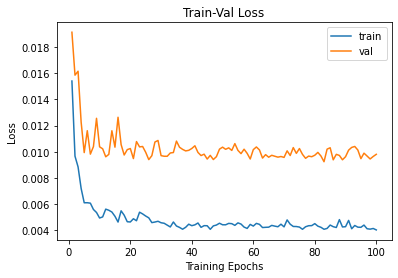

In [139]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

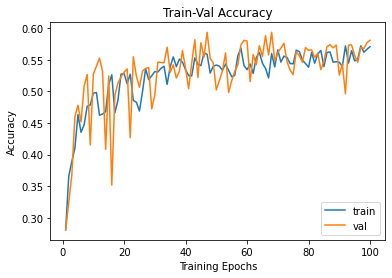

In [140]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

À l'étape 1, nous avons défini une fonction d'assistance pour calculer les valeurs de la métrique de perte et d'IOU par période. La fonction sera utilisée à la fois pour les ensembles de données d'apprentissage et de validation. Pour le jeu de données de validation, aucune optimisation n'est effectuée si opt=None est passé à la fonction. Dans la fonction, des lots de données sont obtenus à partir du chargeur de données dans une boucle. Rappelez-vous que nous devions convertir les étiquettes en tenseurs. Ensuite, les sorties du modèle sont obtenues et la perte et l'IOU ont été calculés par mini-lots à l'aide de la fonction loss_batch.

À l'étape 2, nous avons défini la fonction train_val en quelques étapes pour une meilleure lisibilité du code. Les entrées de la fonction sont le modèle et les paramètres d'apprentissage. Nous avons extrait les clés des paramètres. Ensuite, nous avons défini loss_history et metric_history pour enregistrer les valeurs de perte et de métrique pendant l'entraînement. Pendant la formation, nous voulons conserver les meilleurs paramètres du modèle. Ainsi, nous avons défini best_model_wts pour stocker les meilleurs paramètres du modèle. Pour pouvoir suivre les performances du modèle, nous devons stocker la meilleure valeur de perte. Pour la première époque d'entraînement, il n'y a pas de valeur de perte précédente, nous avons donc initialisé best_loss à un grand nombre ou "inf". Ensuite, la boucle principale démarre, qui s'exécute pour num_epochs itérations. Nous avons imprimé le taux d'apprentissage actuel au début pour garder un œil dessus. Ensuite, nous avons mis le modèle en mode d'entraînement et entraîné le modèle. Cela signifie que la valeur de perte est calculée et que les paramètres du modèle sont mis à jour à l'aide de l'optimiseur, tout cela se passe à l'intérieur de la fonction loss_epoch comme décrit précédemment. Ensuite, nous avons défini le modèle en mode évaluation et évalué le modèle sur les données de validation. Cette fois, aucun calcul de gradient ni optimisation n'ont été nécessaires.

Après chaque évaluation, nous avons comparé la perte de validation actuelle avec la meilleure valeur de perte et stocké les paramètres du modèle si une meilleure perte était observée. Ensuite, nous avons transmis la perte de validation au barème de taux d'apprentissage. Si la perte de validation reste inchangée pendant 20 époques, le programme de taux d'apprentissage réduira le taux d'apprentissage d'un facteur 2. De plus, nous avons imprimé la progression à chaque époque pour surveiller le processus d'apprentissage. Enfin, la boucle se termine et est devenu le modèle le plus performant et l'historique des pertes et des valeurs métriques.



**N'oubliez pas d'arrêter autograd de calculer les gradients lors de l'évaluation du modèle en enveloppant le bloc de code dans with torch.no_grad():**


À l'étape 3, nous avons utilisé la fonction train_val pour réellement entraîner le modèle. Nous avons créé un dossier pour stocker les paramètres du modèle sous forme de fichier pickle. Ensuite, nous avons défini les paramètres d'entraînement dans params_train. Vous pouvez définir l'indicateur sanity_check sur True si vous souhaitez exécuter rapidement la fonction et corriger les éventuelles erreurs. Le drapeau interrompt une période d'entraînement après un mini-lot, ce qui signifie que les boucles sont exécutées plus rapidement. Ensuite, vous pouvez retourner àsanity_check=False. Comme cela a été observé, les valeurs de perte et métriques ont été imprimées.

À l'étape 4, nous avons tracé la perte d'entraînement et de validation et les valeurs d'IOU. Les graphiques montrent les progrès de la formation et de l'évaluation

## Deploying the model

Dans cette recette, nous allons déployer le modèle. Nous allons considérer deux cas de déploiement : le déploiement sur un jeu de données PyTorch et le déploiement sur des images individuelles stockées localement. Étant donné qu'aucun jeu de données de test n'est disponible, nous utiliserons le jeu de données de validation pendant le déploiement. Nous supposons que vous souhaitez déployer le modèle pour l'inférence dans un nouveau script distinct des scripts d'entraînement. Dans ce cas, le jeu de données et le modèle n'existent pas en mémoire. Pour éviter les répétitions, nous allons ignorer la définition de l'ensemble de données et du modèle dans cette section. Suivez les instructions dans Création d'ensembles de données personnalisés et Création des recettes de modèle pour définir l'ensemble de données et le modèle de validation dans le script de déploiement. Dans les scripts suivants, nous supposerons que vous avez défini Net pour la définition du modèle et val_ds andval_dl pour l'ensemble de données de validation

In [142]:
path2weights="./models/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [143]:
from PIL import ImageDraw
import numpy as np
import torchvision.transforms.functional as tv_F
np.random.seed(0)

import matplotlib.pylab as plt
%matplotlib inline

In [144]:
def show_tensor_2labels(img,label1,label2,w_h=(50,50)): 
    label1=rescale_label(label1,img.shape[1:])
    label2=rescale_label(label2,img.shape[1:])
    img=tv_F.to_pil_image(img) 

    w,h=w_h 
    cx,cy=label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=2)

    cx,cy=label2
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="red",width=2)

    plt.imshow(np.asarray(img))

In [146]:
# get random samples
rndInds=np.random.randint(len(val_ds),size=10)
print(rndInds)

[44 47 64 67 67  9 21 36 70 12]


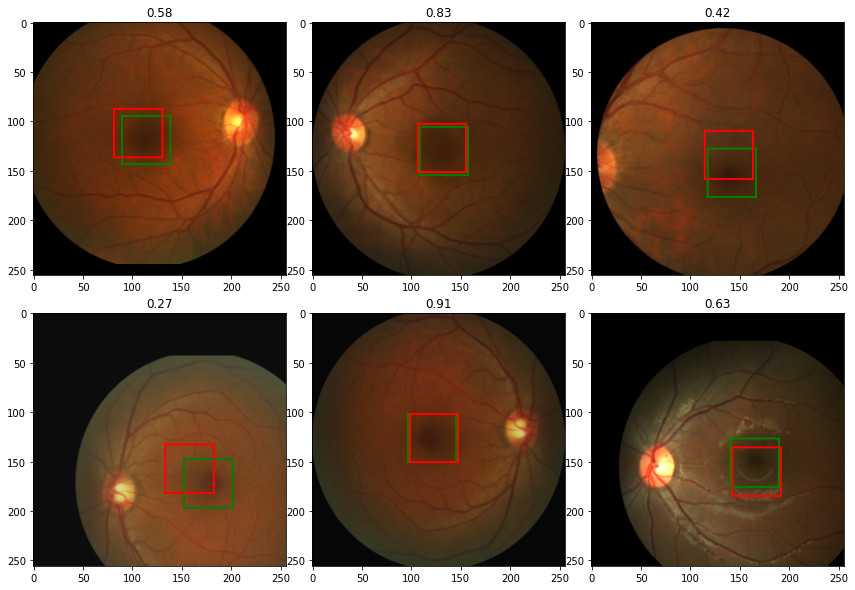

In [147]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.15)

for i,rndi in enumerate(rndInds):
    img,label=val_ds[rndi]
    h,w=img.shape[1:]
    with torch.no_grad():
        label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
        
    plt.subplot(2,3,i+1)
    show_tensor_2labels(img,label,label_pred)
    
    # calculate IOU 
    label_bb=cxcy2bbox(torch.tensor(label).unsqueeze(0))
    label_pred_bb=cxcy2bbox(label_pred.unsqueeze(0))
    iou=torchvision.ops.box_iou(label_bb, label_pred_bb)        
    plt.title("%.2f" %iou.item())

    if i>4:
        break

In [148]:
def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256])


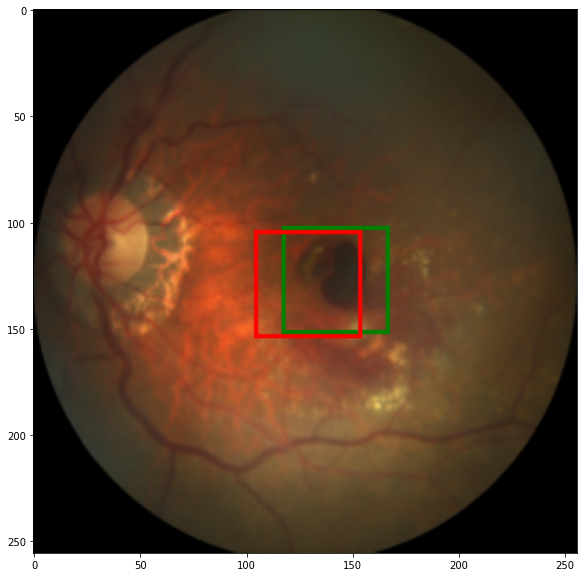

In [150]:

path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")
labels_df=pd.read_excel(path2labels,index_col="ID")

img,label=load_img_label(labels_df,1)   
print(img.size, label)

img,label=resize_img_label(img,label,target_size=(256,256))
print(img.size, label)

img=TF.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape)

with torch.no_grad():
    label_pred=model(img.unsqueeze(0).to(device))[0].cpu()

show_tensor_2labels(img,label,label_pred)

In [151]:
import time
elapsed_times=[]
with torch.no_grad():
    for k in range(100):
        start=time.time()
        label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
        elapsed=time.time()-start
        elapsed_times.append(elapsed)
print("inference time per image: %.4f s" %np.mean(elapsed_times))

inference time per image: 0.0113 s
